# Import Dependencies

In [1]:
import gc
import glob
import os

import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

%matplotlib inline

from keras.callbacks import *
from keras.models import load_model
from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Define SaltParser

In [2]:
class SaltParser(object):

    '''
    Parser for Salt Competition.
    
    # Arguments:
        data_src: directory containing data
        grayscale: whether to load images as grayscale
        load_test_data: whether to load test data
    '''

    def __init__(self, data_src):

        self.data_src = data_src

        self.train_df = None
        self.test_df = None
        self.padding_pixels = None
        self.orig_image_size = None

        self.X_train = []
        self.y_train = []
        self.X_test = []
        

    def load_csv_data(self):
        
        '''
        Initialize processing by loading .csv files.
        After loading, train_df and test_df will have column 'id' for each unique image
        and 'z' for depth
        '''

        train_df = pd.read_csv(f'{self.data_src}train.csv', usecols=[0], index_col='id')
        depths_df = pd.read_csv(f'{self.data_src}depths.csv', index_col='id')
        self.train_df = train_df.join(depths_df)
        self.test_df = depths_df[~depths_df.index.isin(train_df.index)]

        return

    
    def load_img_data(self):
        
        '''
        Load images and masks from training set. Can only be executed after load_csv_data()
        
        # Returns:
            self.X_train: np.array of training images
            self.y_train: np.array of training masks
            self.X_test: np.array of test images
        '''

        print("Loading training images...")
        self.X_train = [np.array(cv2.imread(f"{self.data_src}train/images/{idx}.png", 0)) for idx in tqdm_notebook(self.train_df.index)]
        self.X_train = np.asarray(self.X_train)       
        self.X_train = np.expand_dims(self.X_train, -1)
        print(f'X_train shape: {self.X_train.shape}')
        print(f'X_train - min: {np.min(self.X_train)}, max: {np.max(self.X_train)}')
        
        print("\n\nLoading training masks...")
        self.y_train = [np.array(cv2.imread(f"{self.data_src}train/masks/{idx}.png", 0)) for idx in tqdm_notebook(self.train_df.index)]
        self.y_train = np.asarray(self.y_train)
        self.y_train = np.expand_dims(self.y_train, -1)
        print(f'y_train shape: {self.y_train.shape}')
        print(f'y_train - min: {np.min(self.y_train)}, max: {np.max(self.y_train)}')

        print("\n\nLoading test images...")
        self.X_test = [np.array(cv2.imread(f"{self.data_src}test/images/{idx}.png", 0)) for idx in tqdm_notebook(self.test_df.index)]
        self.X_test = np.asarray(self.X_test)
        self.X_test = np.expand_dims(self.X_test, -1)  
        print(f'X_test shape: {self.X_test.shape}')
        print(f'X_test - min: {np.min(self.X_test)}, max: {np.max(self.X_test)}')

        return self.X_train, self.y_train, self.X_test
    
    
    def preprocess(self, normalized=False, image_resized_size=None, padding=None):
        scale = 1
        if normalized:
            scale = 1 / 255.
            
        X_train_proc = self.X_train * scale
        y_train_proc = self.y_train * scale
        X_test_proc = self.X_test * scale
            
        X_train_list = []
        y_train_list = []
        X_test_list = []
        
        print('Preprocessing training set...')
        for i in tqdm_notebook(range(X_train_proc.shape[0])):
            img_tmp = X_train_proc[i,:,:,0]
            mask_tmp = y_train_proc[i,:,:,0]
            
            if image_resized_size:
                img_tmp = cv2.resize(img_tmp, image_resized_size)
                mask_tmp = cv2.resize(mask_tmp, image_resized_size)

            if padding:
                img_tmp = cv2.copyMakeBorder(img_tmp,
                                              padding, padding,
                                              padding, padding,
                                              cv2.BORDER_REFLECT_101)
                mask_tmp = cv2.copyMakeBorder(mask_tmp,
                                              padding, padding,
                                              padding, padding,
                                              cv2.BORDER_REFLECT_101)
            X_train_list.append(img_tmp)
            y_train_list.append(mask_tmp)
            
        print('\nPreprocessing test set...')
        for i in tqdm_notebook(range(X_test_proc.shape[0])):
            img_tmp = X_test_proc[i,:,:,0]
            
            if image_resized_size:
                img_tmp = cv2.resize(img_tmp, image_resized_size)

            if padding:
                img_tmp = cv2.copyMakeBorder(img_tmp,
                                              padding, padding,
                                              padding, padding,
                                              cv2.BORDER_REFLECT_101)
            X_test_list.append(img_tmp)
            
            
        X_train_proc = np.expand_dims(X_train_list, -1)          
        y_train_proc = np.expand_dims(y_train_list, -1)         
        X_test_proc = np.expand_dims(X_test_list, -1)         
            
        print(f'X_train shape: {X_train_proc.shape}')
        print(f'X_train - min: {np.min(X_train_proc)}, max: {np.max(X_train_proc)}')
        
        print(f'y_train shape: {y_train_proc.shape}')
        print(f'y_train - min: {np.min(y_train_proc)}, max: {np.max(y_train_proc)}')
        
        print(f'X_test shape: {X_test_proc.shape}')
        print(f'X_test - min: {np.min(X_test_proc)}, max: {np.max(X_test_proc)}')
        
        return X_train_proc, y_train_proc, X_test_proc


    def compute_coverage(self):
        
        '''
        Compute salt coverage of each mask. This will serve as a basis for 
        stratified split between training and validation sets.
        
        # Returns:
            self.train_df: training DF containing coverage information.
        '''

        print('Compute mask coverage for each observation.')
        self.train_df['coverage'] = np.mean(self.y_train / 255., axis=(1, 2))
        self.train_df["coverage_class"] = self.train_df.coverage.apply(lambda val: np.int(np.ceil(val*10)))

        return self.train_df

    def predictions_rle_encode(self, y_pred_test, confidence_threshold_best):
        
        '''
        Run Length Encoding of predictions.
        This is needed for submission output.
        
        # Arguments:
            y_pred_test: model predictions
            confidence_threshold_best: confidence threshold, according to which
                masks are set to 1/0.
        # Returns:
            y_test_pred_rle: RLEncoded predictions.
        '''

        # If images were padded, this padding must now be removed.
        # Otherwise encoding method will fail to properly encode predictions and
        # score will be bad.
        if self.pad_images:
            print('Remove padding from images.')
            y_min_pad, y_max_pad, x_min_pad, x_max_pad = self.padding_pixels[
                0], self.padding_pixels[1], self.padding_pixels[2], self.padding_pixels[3]
            y_pred_test = y_pred_test[:, y_min_pad:-
                                      y_max_pad, x_min_pad:-x_max_pad, 0]
            
        # Situation is similar for previously resized images.
        # They must be resized again to their original size before encoding.
        else:
            y_pred_test = np.asarray([cv2.resize(x, self.orig_image_size)
                                      for x in y_pred_test])

        assert y_pred_test.shape == (18000, 101, 101), '\
        Test predictions shape must be equal to (18000, 101, 101).'

        print('Test predictions shape: {}'.format(y_pred_test.shape))

        # Perform mask predictions binarization and RLEncoding. 
        y_test_pred_rle = {idx:
                           rle_encode(y_pred_test[i] > confidence_threshold_best)
                           for i, idx in enumerate(
                               tqdm(self.test_df.index.values))}

        return y_test_pred_rle

    def generate_submission(self, y_test_pred_rle):
        
        '''
        Submission generation based on encoded model predictions.
        
        # Arguments:
            y_test_pred_rle: RLEncoded predictions.
        # Returns:
            submission: generated submission.
        '''

        submission = pd.DataFrame.from_dict(y_test_pred_rle, orient='index')
        submission.index.names = ['id']
        submission.columns = ['rle_mask']

        return submission

    def return_padding_borders(self):
        '''
        Return padding borders in case intermediate operations on original images
        are needed.
        
        # Returns:
            self.padding_pixels: tuple of padding borders.
        '''
        return self.padding_pixels

# Define helper functions:

In [3]:
# Quick RLEncoding needed for submission generation.
# Source: another kernel, thanks!
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Initialize parameters:

In [4]:
salt_parser = SaltParser('data/salt/')

## Initialize and load data - call SaltParser functions:

In [5]:
salt_parser.load_csv_data()
print(salt_parser.train_df.shape, salt_parser.test_df.shape)

(4000, 1) (18000, 1)


In [6]:
X_train, y_train, X_test = salt_parser.load_img_data()

Loading training images...



X_train shape: (4000, 101, 101, 1)
X_train - min: 0, max: 255


Loading training masks...



y_train shape: (4000, 101, 101, 1)
y_train - min: 0, max: 255


Loading test images...



X_test shape: (18000, 101, 101, 1)
X_test - min: 0, max: 255


In [7]:
train_df = salt_parser.compute_coverage()

Compute mask coverage for each observation.


C:\Users\szelee\Miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Coverage class')

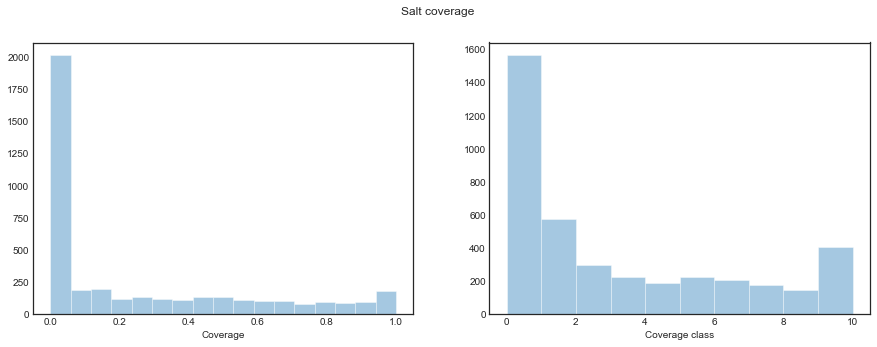

In [8]:
# Plotting the salt coverage distributions
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

C:\Users\szelee\Miniconda3\envs\tf\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Depth distribution')

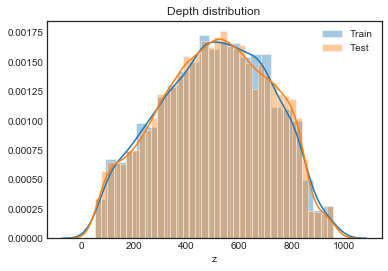

In [9]:
# Plotting the depth distributions
sns.distplot(salt_parser.train_df.z, label="Train")
sns.distplot(salt_parser.test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [10]:
padding_pixels = salt_parser.return_padding_borders()

## 3. Preprocess raw input data

In [11]:
img_size_target = 256
X_train, y_train, X_test = salt_parser.preprocess(normalized=True, image_resized_size=(202,202), padding=27)

Preprocessing training set...




Preprocessing test set...



X_train shape: (4000, 256, 256, 1)
X_train - min: 0.0, max: 1.0
y_train shape: (4000, 256, 256, 1)
y_train - min: 0.0, max: 1.0
X_test shape: (18000, 256, 256, 1)
X_test - min: 0.0, max: 1.0


In [16]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)

## Sanity Check

Text(0.5,1,'2x-scaled image and reflected padding')

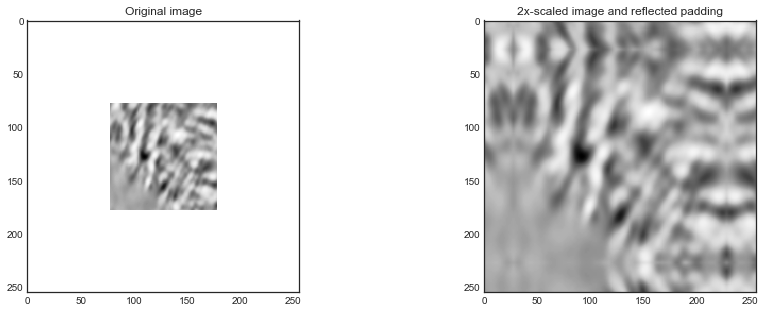

In [28]:
idx = 3
tmp_img = np.zeros((256,256), dtype=np.float64)
tmp_img[78:179, 78:179] = salt_parser.X_train[idx,:,:,0]

fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(X_train[idx].squeeze(), cmap="Greys")
axs[1].set_title("2x-scaled image and reflected padding")

## 4. Perform stratified training/validation split based on coverage.

In [29]:
# Perform 80/20 training/validation split based on stratified coverage.
X_tr, X_val, y_tr, y_val, cov_train, cov_test, depth_train, depth_test = train_test_split(
    X_train,
    y_train,
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, 
    stratify=train_df.coverage_class, 
    random_state=1234)

del train_df
gc.collect()

del X_train, y_train
gc.collect()

0

## Define UNet model for training.

In [30]:
from keras import Model
from keras.layers import (Activation, BatchNormalization, Concatenate, Conv2D,
                          Conv2DTranspose, Dropout, Input, MaxPooling2D,
                          UpSampling2D, concatenate)
from keras.optimizers import Adam

In [31]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [ ]:
# Build Model
def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # 256 -> 128
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 128 -> 64
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 64 -> 32
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 32 -> 16
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # 16 -> 8
    conv5 = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    conv5 = residual_block(conv5, start_neurons*16)
    conv5 = residual_block(conv5, start_neurons*16, True)
    pool5 = MaxPooling2D((2,2))(conv5)
    pool5 = Dropout(DropoutRatio)(pool5)
    
    # Middle
    convm = Conv2D(start_neurons*32, (3,3), activation=None, padding='same')(pool5)
    convm = residual_block(convm, start_neurons*32)
    convm = residual_block(convm, start_neurons*32, True)
    
    # 8 -> 16
    deconv5 = Conv2DTranspose(start_neurons*16, (3,3), strides=(2,2), padding='same')(convm)
    uconv5 = concatenate([deconv5, conv5])
    uconv5 = Dropout(DropoutRatio)(uconv5)
    
    uconv5 = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(uconv5)
    uconv5 = residual_block(uconv5, start_neurons*16)
    uconv5 = residual_block(uconv5, start_neurons*16, True)
    
    # 16 -> 32
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(uconv5)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 32 -> 64
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 64 -> 128
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 128 -> 256
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

# Metric Loss

In [ ]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [ ]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

In [ ]:
def focal_loss(gamma = 2., alpha = 0.75):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-6, 1 - 1e-6)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1. - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), K.ones_like(y_pred) * K.constant(alpha), K.ones_like(y_pred) * K.constant(1. - alpha))
        loss = K.mean(-1. * alpha_t * (1. - p_t)**gamma * K.log(p_t))
        return loss
    return focal_loss_fixed

# Build Model

In [ ]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)

model1 = Model(input_layer, output_layer)

In [ ]:
epochs = 300
batch_size = 64
c = optimizers.Adam(lr=0.001)

model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

# model1.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode='max', patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=6, min_lr=0.00001, verbose=1)

## Train model:

In [ ]:
%%time
history = model1.fit(x_train, y_train,
                     validation_data = [x_valid, y_valid], 
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 2)

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

## Predict 

In [54]:
model1 = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})

input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.0005)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

# model.summary()

In [55]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

In [56]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 6334 samples, validate on 796 samples
Epoch 1/200
 - 209s - loss: -9.7570e-02 - my_iou_metric_2: 0.7949 - val_loss: 0.2871 - val_my_iou_metric_2: 0.7031

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.70314, saving model to unet_v2_5B_cv4.model
Epoch 2/200
 - 192s - loss: -1.1059e-01 - my_iou_metric_2: 0.7961 - val_loss: 0.0132 - val_my_iou_metric_2: 0.7614

Epoch 00002: val_my_iou_metric_2 improved from 0.70314 to 0.76143, saving model to unet_v2_5B_cv4.model
Epoch 3/200
 - 192s - loss: -1.3595e-01 - my_iou_metric_2: 0.7982 - val_loss: 0.0796 - val_my_iou_metric_2: 0.7412

Epoch 00003: val_my_iou_metric_2 did not improve from 0.76143
Epoch 4/200
 - 192s - loss: -1.3286e-01 - my_iou_metric_2: 0.7971 - val_loss: 0.0544 - val_my_iou_metric_2: 0.7480

Epoch 00004: val_my_iou_metric_2 did not improve from 0.76143
Epoch 5/200
 - 192s - loss: -1.5857e-01 - my_iou_metric_2: 0.8013 - val_loss: -8.1001e-02 - val_my_iou_metric_2: 0.7761

Epoch 00005: val_my_iou_metric_2 improv

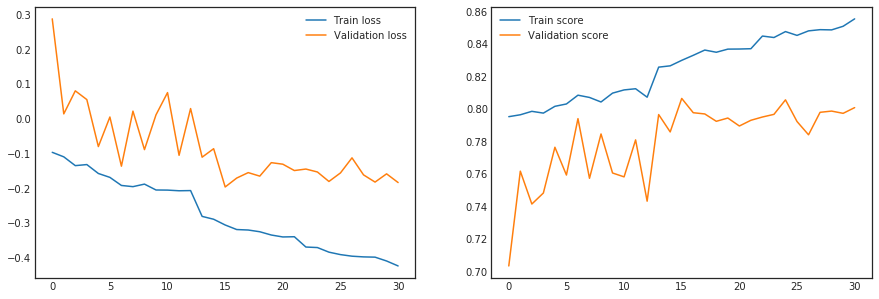

In [59]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

# Final Tuning

In [63]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

c = optimizers.Adam(lr = 0.0001)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

epochs = 200
batch_size = 16

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=12, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=5, min_lr=0.00001, verbose=2)

In [64]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 6334 samples, validate on 796 samples
Epoch 1/200
 - 252s - loss: -2.7873e-01 - my_iou_metric_2: 0.8245 - val_loss: -1.7559e-01 - val_my_iou_metric_2: 0.8054

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.80540, saving model to unet_v2_5B_cv4.model
Epoch 2/200
 - 229s - loss: -2.8735e-01 - my_iou_metric_2: 0.8276 - val_loss: -1.4770e-01 - val_my_iou_metric_2: 0.7935

Epoch 00002: val_my_iou_metric_2 did not improve from 0.80540
Epoch 3/200
 - 229s - loss: -2.9710e-01 - my_iou_metric_2: 0.8273 - val_loss: -1.5434e-01 - val_my_iou_metric_2: 0.7938

Epoch 00003: val_my_iou_metric_2 did not improve from 0.80540
Epoch 4/200
 - 229s - loss: -3.1202e-01 - my_iou_metric_2: 0.8314 - val_loss: -1.5490e-01 - val_my_iou_metric_2: 0.7962

Epoch 00004: val_my_iou_metric_2 did not improve from 0.80540
Epoch 5/200
 - 229s - loss: -3.1182e-01 - my_iou_metric_2: 0.8317 - val_loss: -1.2431e-01 - val_my_iou_metric_2: 0.7814

Epoch 00005: val_my_iou_metric_2 did not improve from 0.80540

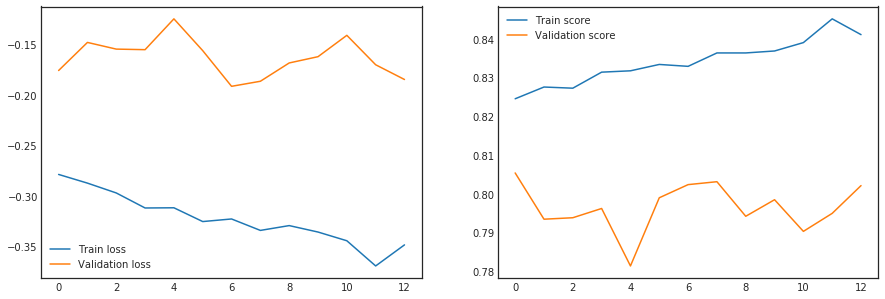

In [65]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [66]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [67]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [68]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [69]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [70]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.80100503 0.80113065 0.80138191 0.80364322 0.80364322 0.80326633
 0.80389447 0.80389447 0.80276382 0.80452261 0.80414573 0.80326633
 0.8048995  0.80464824 0.80464824 0.80603015 0.80603015 0.80527638
 0.80515075 0.80703518 0.80690955 0.80665829 0.80628141 0.80628141
 0.80515075 0.8048995  0.8048995  0.80376884 0.80276382 0.80276382
 0.80188442]


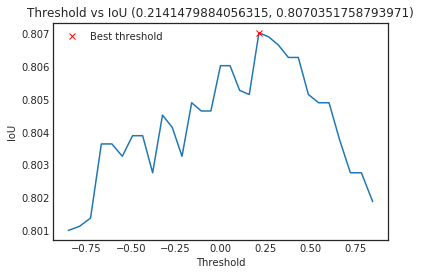

In [71]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [72]:
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [73]:
x_test = np.array([(np.array(load_img(f"{DATA_DIR}test/images/{idx}.png", color_mode='grayscale'))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [74]:
preds_test = predict_result(model,x_test,img_size_target)

In [75]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [76]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [77]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 5.09862830526299 hours
